In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import sys
sys.path.append('C:\\Users\\Peace\\Documents\\Project\\Final\\')
import features

D:\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# %%
# Loading train and test data

In [3]:
path = "C:\\Users\\Peace\\Documents\\Project\\Final\\"
data = pd.read_csv(path + 'data.csv')
data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [4]:
train = data.iloc[:363861]
test = data.iloc[363861:]
print(train.info(memory_usage='deep')) # Using memory_usage parameter to include the size of object datatype columns too

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363861 entries, 0 to 363860
Data columns (total 6 columns):
id              363861 non-null int64
qid1            363861 non-null int64
qid2            363861 non-null int64
question1       363860 non-null object
question2       363859 non-null object
is_duplicate    363861 non-null int64
dtypes: int64(4), object(2)
memory usage: 92.9 MB
None


In [5]:
# %%
# Dropping id, qid1, qid2 columns - plays no role

In [6]:
train = train.loc[:, ['question1', 'question2', 'is_duplicate']]
print(train.head())

                                           question1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [8]:
# %%
# Finding if there are any missing values in the data

In [7]:
print(train.isnull().sum())

question1       1
question2       2
is_duplicate    0
dtype: int64


In [8]:
train.dropna(subset=['question1', 'question2'], inplace=True)

In [9]:
print(train.isnull().sum())

question1       0
question2       0
is_duplicate    0
dtype: int64


In [10]:
# %%
# Making question columns to lowercase
train.question1 = train.question1.str.lower()
train.question2 = train.question2.str.lower()

In [11]:
# %%
# Creating features of the train data and storing them in the x_train DataFrame

In [12]:
x_train = pd.DataFrame()
x_train["X1"] = train.apply(features.word_match_share, axis=1, raw=True)
x_train["X2"] = train.apply(features.tfidf_word_match_share, axis=1, raw=True)
x_train["X3"] = pd.DataFrame(features.common_words_count(train))
X4, X5 = features.fuzz_sort_set(train)
x_train["X4"] = X4
x_train["X5"] = X5

In [13]:
# %%
# Inferences from the first feature - Word Match Share 

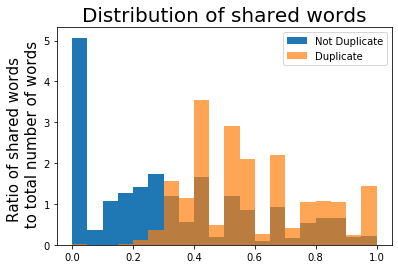

In [14]:
plt.hist(x_train.X1[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X1[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of shared words', fontsize=20)
plt.ylabel('Ratio of shared words \n to total number of words', fontsize=15)
plt.show()

In [15]:
# Inference from the above plot: Most of the questions (excluding the overlapping ones) 
# can be classified as duplicate and non-duplicate as confirmed from the graph.

# %%
# Inferences from the second feature - TF-IDF Word Match Share 

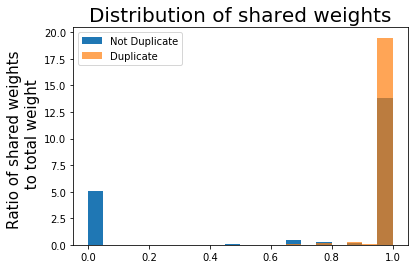

In [16]:
plt.hist(x_train.X2[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X2[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of shared weights', fontsize=20)
plt.ylabel('Ratio of shared weights \n to total weight', fontsize=15)
plt.show()

In [17]:
# Even this feature is helpful in classifying either duplicate or not

# %%
# Inferences from the third feature - Common words count

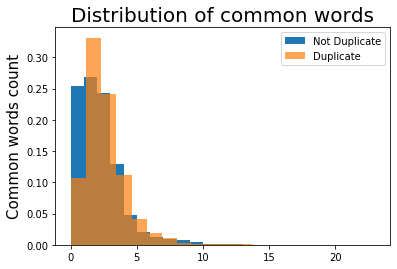

In [18]:
plt.hist(x_train.X3[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X3[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of common words', fontsize=20)
plt.ylabel('Common words count', fontsize=15)
plt.show()

In [19]:
# This feature may be slightly helpul as most of the data is overlapping

# %%
# Inferences from the third feature - Token Sort Ratio

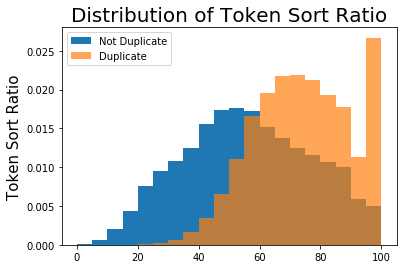

In [20]:
plt.hist(x_train.X4[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X4[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of Token Sort Ratio', fontsize=20)
plt.ylabel('Token Sort Ratio', fontsize=15)
plt.show()

In [21]:
# This one is quite helpful as a good amount of data is not overlapping

# %%
# Inferences from the third feature - Token Set Ratio

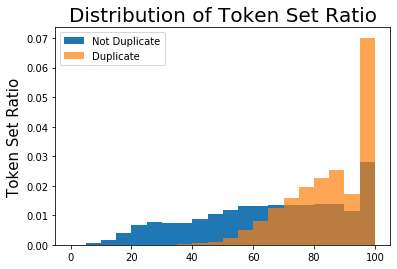

In [22]:
plt.hist(x_train.X5[train['is_duplicate'] == 0], bins=20, density=True, label='Not Duplicate')
plt.hist(x_train.X5[train['is_duplicate'] == 1], bins=20, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Distribution of Token Set Ratio', fontsize=20)
plt.ylabel('Token Set Ratio', fontsize=15)
plt.show()

In [23]:
# Perfect, even this feature provides good insights.

# %%
# Analyzing these features based on ROC AUC metric

In [24]:
print('          Original AUC:', roc_auc_score(train['is_duplicate'], x_train.X1))
print('             TFIDF AUC:', roc_auc_score(train['is_duplicate'], x_train.X2.fillna(0)))
print('Common Word Counts AUC:', roc_auc_score(train['is_duplicate'], x_train.X3))
print('  Token Sort Ratio AUC:', roc_auc_score(train['is_duplicate'], x_train.X4))
print('   Token Set Ratio AUC:', roc_auc_score(train['is_duplicate'], x_train.X5))

          Original AUC: 0.7805390226279744
             TFIDF AUC: 0.6572456723898616
Common Word Counts AUC: 0.7270832207440432
  Token Sort Ratio AUC: 0.7445668964679596
   Token Set Ratio AUC: 0.7441439825333955


In [25]:
# Inference - Feature importance is shown below:
# X1 > X5 > X4 > X3 > X2

# %%

# Splitting data in train and validation set for model building
# Considering 20% data as validation data

In [26]:
X_t, X_v, y_t, y_v = train_test_split(x_train, train['is_duplicate'].values,
                                      test_size=0.2, random_state=42)

In [27]:
# %%
# Model Building - XGBoost

# Setting parameters

In [28]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 2

d_train = xgb.DMatrix(X_t, label=y_t)
d_valid = xgb.DMatrix(X_v, label=y_v)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [29]:
# Training the model

In [30]:
XGboostModel = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68621	valid-logloss:0.68636
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.63040	valid-logloss:0.63040
[20]	train-logloss:0.59098	valid-logloss:0.59089
[30]	train-logloss:0.56190	valid-logloss:0.56192
[40]	train-logloss:0.54012	valid-logloss:0.54012
[50]	train-logloss:0.52348	valid-logloss:0.52356
[60]	train-logloss:0.51072	valid-logloss:0.51078
[70]	train-logloss:0.50079	valid-logloss:0.50083
[80]	train-logloss:0.49291	valid-logloss:0.49298
[90]	train-logloss:0.48655	valid-logloss:0.48679
[100]	train-logloss:0.48173	valid-logloss:0.48184
[110]	train-logloss:0.47784	valid-logloss:0.47789
[120]	train-logloss:0.47451	valid-logloss:0.47475
[130]	train-logloss:0.47198	valid-logloss:0.47220
[140]	train-logloss:0.47022	valid-logloss:0.47019
[150]	train-logloss:0.46849	valid-logloss:0.46853
[160]	train-logloss:0.46692	valid-logloss:0.46719
[170]	trai

In [31]:
# Saving the model parameters in an external file

In [32]:
joblib.dump(XGboostModel, path + "XGboostModel.sav")

['C:\\Users\\Peace\\Documents\\Project\\Final\\XGboostModel.sav']

In [33]:
# %%
# Model Building - LGBoost

# Setting parameters

In [34]:
params = {}
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'    
params['eta'] = 0.02
params['max_depth'] = 2

lgtrain = lgb.Dataset(X_t, label=y_t)
lgval = lgb.Dataset(X_v, label=y_v)

LGboostModel = lgb.train(params, lgtrain, 400, valid_sets=[lgtrain, lgval], early_stopping_rounds=50, verbose_eval=10)

Training until validation scores don't improve for 50 rounds
[10]	training's binary_logloss: 0.60922	valid_1's binary_logloss: 0.608192
[20]	training's binary_logloss: 0.573245	valid_1's binary_logloss: 0.572437
[30]	training's binary_logloss: 0.547043	valid_1's binary_logloss: 0.546418
[40]	training's binary_logloss: 0.527636	valid_1's binary_logloss: 0.527156
[50]	training's binary_logloss: 0.513096	valid_1's binary_logloss: 0.512741
[60]	training's binary_logloss: 0.502125	valid_1's binary_logloss: 0.50187
[70]	training's binary_logloss: 0.493619	valid_1's binary_logloss: 0.493448
[80]	training's binary_logloss: 0.48698	valid_1's binary_logloss: 0.486876
[90]	training's binary_logloss: 0.481793	valid_1's binary_logloss: 0.48175
[100]	training's binary_logloss: 0.47767	valid_1's binary_logloss: 0.477668
[110]	training's binary_logloss: 0.474496	valid_1's binary_logloss: 0.474533
[120]	training's binary_logloss: 0.471972	valid_1's binary_logloss: 0.472037
[130]	training's binary_loglo

In [35]:
# Saving the model parameters in an external file

In [36]:
joblib.dump(LGboostModel, path + "LGboostModel.sav")

['C:\\Users\\Peace\\Documents\\Project\\Final\\LGboostModel.sav']

In [37]:
# %%
# Model building - CatBoost

In [38]:
cb_model = CatBoostRegressor(iterations=500, learning_rate=0.02, depth=10, 
                             eval_metric='RMSE', metric_period = 50)
CATboostModel = cb_model.fit(X_t, y_t, eval_set=(X_v, y_v), use_best_model=True, verbose=50)

0:	learn: 0.4802060	test: 0.4795277	best: 0.4795277 (0)	total: 195ms	remaining: 1m 37s
50:	learn: 0.4070824	test: 0.4067815	best: 0.4067815 (50)	total: 4.61s	remaining: 40.6s
100:	learn: 0.3946559	test: 0.3945876	best: 0.3945876 (100)	total: 8.68s	remaining: 34.3s
150:	learn: 0.3921785	test: 0.3922478	best: 0.3922478 (150)	total: 12.2s	remaining: 28.3s
200:	learn: 0.3913125	test: 0.3914979	best: 0.3914979 (200)	total: 16.2s	remaining: 24s
250:	learn: 0.3907852	test: 0.3910836	best: 0.3910836 (250)	total: 20.5s	remaining: 20.3s
300:	learn: 0.3903809	test: 0.3908200	best: 0.3908200 (300)	total: 25s	remaining: 16.6s
350:	learn: 0.3900950	test: 0.3906362	best: 0.3906362 (350)	total: 28.9s	remaining: 12.3s
400:	learn: 0.3898115	test: 0.3904819	best: 0.3904819 (400)	total: 32.6s	remaining: 8.04s
450:	learn: 0.3895854	test: 0.3903626	best: 0.3903626 (450)	total: 36.3s	remaining: 3.94s
499:	learn: 0.3894131	test: 0.3902919	best: 0.3902919 (499)	total: 39.9s	remaining: 0us

bestTest = 0.3902919

In [39]:
# Saving the model parameters in an external file

In [40]:
joblib.dump(CATboostModel, path + "CATboostModel.sav")

['C:\\Users\\Peace\\Documents\\Project\\Final\\CATboostModel.sav']

In [41]:
# %%
# Creating a test data

In [45]:
test_sub = test.loc[:,["question1", "question2"]].apply(lambda x: x.str.lower())

In [46]:
test_sub

,question1,question2
363861,how do you become both a lawyer and a doctor?,how can you become a lawyer?
363862,how do i get rid of the smell from a cat spray...,how can i stop my cat from spraying?
363863,how does one start a small business?,how can i start a successful small business?
363864,which are the best gmat coaching institutes in...,what is the best coaching institute for gmat i...
363865,what are some good jobs for civil engineer?,which are the best jobs in civil engineering?
363866,what does a product developer do?,what is product development?
363867,which company has the best image recognition a...,who are the best image recognition providers f...
363868,do employees at myriad genetics have a good wo...,dos and donts on dropbox?
363869,can i make money online?,what are the best ways to make money online?
363870,does an increase in climatic temperature cause...,at what temperature/ conditions can petrol fue...


In [47]:
x_test = pd.DataFrame()
x_test["X1"] = test_sub.apply(features.word_match_share, axis=1, raw=True)
x_test["X2"] = test_sub.apply(features.tfidf_word_match_share, axis=1, raw=True)
x_test["X3"] = pd.DataFrame(features.common_words_count(test_sub))
X4, X5 = features.fuzz_sort_set(test_sub)
x_test["X4"] = X4
x_test["X5"] = X5

In [48]:
# %%
# Checking the models on few test data

In [49]:
XG = joblib.load(path + "XGboostModel.sav")
LG = joblib.load(path + "LGboostModel.sav")
CAT = joblib.load(path + "CATboostModel.sav")

In [50]:
# XGBoost prediction

In [51]:
XG_pred = XG.predict(xgb.DMatrix(x_test)) * 100

In [52]:
# LGBoost prediction

In [53]:
LG_pred = np.expm1(LG.predict(x_test, num_iteration=LG.best_iteration)) * 100

In [54]:
# CATBoost prediction

In [55]:
CAT_pred = np.expm1(CAT.predict(x_test)) * 100

In [56]:
# %%

In [58]:
final_pred = test.loc[:, ["question1", "question2", "is_duplicate"]]
final_pred["XGBoost Prediction in Percentage"] = XG_pred
final_pred["LGBoost Prediction in Percentage"] = LG_pred
final_pred["CATBoost Prediction in Percentage"] = CAT_pred
print(final_pred)

                                                question1  \
363861      How do you become both a lawyer and a doctor?   
363862  How do I get rid of the smell from a cat spray...   
363863               How does one start a small business?   
363864  Which are the best GMAT coaching institutes in...   
363865        What are some good jobs for civil engineer?   
363866                  What does a product developer do?   
363867  Which company has the best image recognition A...   
363868  Do employees at Myriad Genetics have a good wo...   
363869                           Can I make money online?   
363870  Does an increase in climatic temperature cause...   
363871  I am unable to add my SBI debit card (Masterca...   
363872  What are the requisites to join the Canadian a...   
363873  Will there be a need for human operated aircra...   
363874  Is it a problem if the name of some of the pas...   
363875  Why do soldiers on the right side of parade fo...   
363876  What are the mos